In [27]:
import numpy as np
import pandas as pd
from load_data import load_argo, load_moana_tds, load_moana_db
from plot_data import plot_map, monthly_bar_plot

# Specify time and spatial ranges

In [2]:
# Specify start and end dates
start_date = np.datetime64("2024-01-01")
end_date = np.datetime64("2024-12-08")

# Define grids for map
# box = [lon_1,lon_2,lat_1,lat_2]
box = [161, 190, -52, -31]
# Grid cell resolution in degrees lon/lat
res = 1

# Load Argo and Mangōpare/Moana data

In [3]:
argo = load_argo()

/Users/jkat/miniconda3/envs/plots_env/lib/python3.12/site-packages/erddapy/core/interfaces.py:39: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(data, **(pandas_kwargs or {}))
/Users/jkat/miniconda3/envs/plots_env/lib/python3.12/site-packages/erddapy/core/interfaces.py:39: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(data, **(pandas_kwargs or {}))


In [4]:
# load moana data from THREDDS or other directory
# moana, stats_moana, time = load_moana_tds()
# load moana from sqlite database
moana, stats_moana, time = load_moana_db(
    source="sqlite:////Users/jkat/source/moana-plots/moana.db"
)

# Map of horizontal geospatial coverage

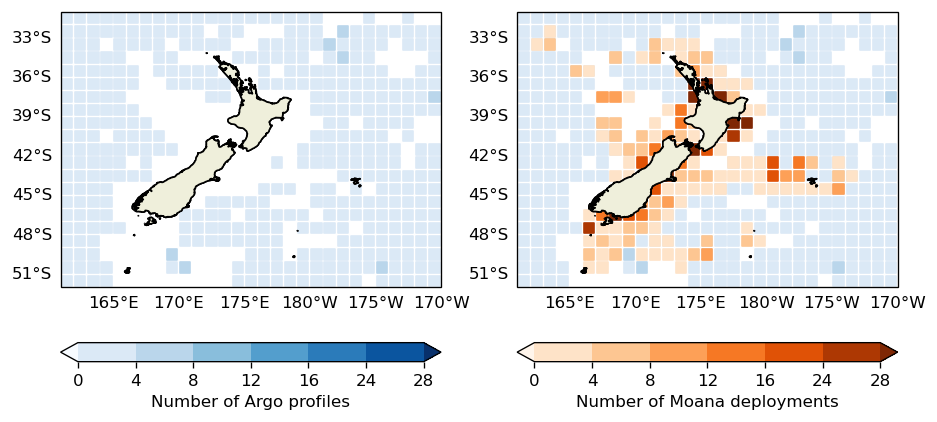

/var/folders/x3/2vkg00ln6rd9yvrqz14ky4xh0000gn/T/ipykernel_79335/1784497351.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [5]:
# plot parameters
ms = 38
bounds = [0, 4, 8, 12, 16, 24, 28]
lon_offset = 180

%matplotlib inline
fig = plot_map(argo,moana)

fig.show()

# Create bar plot of number of deployments/profiles over time

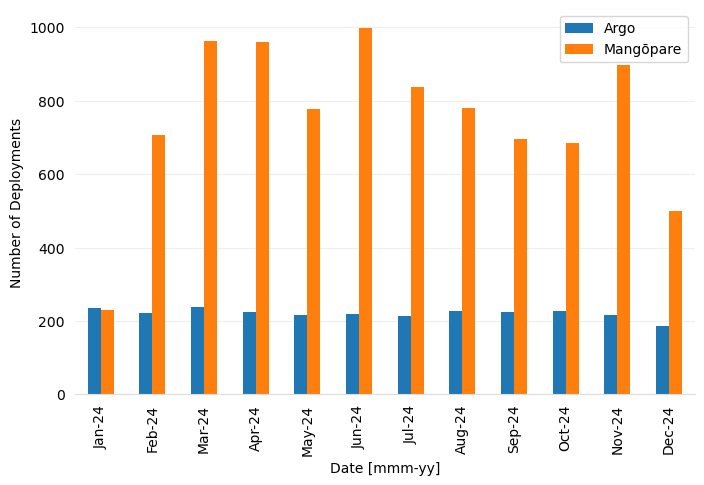

In [6]:
monthly_bar_plot(argo,moana)

# Calculating Monthly Stats

In [35]:
moana2 = pd.DataFrame(moana, copy=True)
moana2['num_obs'] = stats_moana['num_measurements']
# Calculate number of measurements (observations) per month
moana2.groupby(pd.Grouper(key="time", freq="ME")).sum().drop(columns=['lat','lon']).reset_index()

,time,num_obs
0,2023-12-31 00:00:00+00:00,14916
1,2024-01-31 00:00:00+00:00,86307
2,2024-02-29 00:00:00+00:00,189077
3,2024-03-31 00:00:00+00:00,156914
4,2024-04-30 00:00:00+00:00,125576
5,2024-05-31 00:00:00+00:00,130273
6,2024-06-30 00:00:00+00:00,220765
7,2024-07-31 00:00:00+00:00,153584
8,2024-08-31 00:00:00+00:00,213851
9,2024-09-30 00:00:00+00:00,249965
